In [1]:
# Plot Package
import matplotlib
matplotlib.use('AGG')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white") 

# display plots in this notebook
%matplotlib inline

In [2]:
## This file contains the basic function of read data and clean filter.
## Author: Xiang Li

###Sample
#### Imput Package
from pandas import pandas as pd
import numpy
import os
from scipy import stats
from optparse import OptionParser
from matplotlib import pyplot as plt
import HTSeq


In [6]:
def Distribute_By_Pileup(input_tag_file):
    ga = HTSeq.GenomicArray("auto", stranded=False, typecode="d")
    bedfile = HTSeq.BED_Reader(input_tag_file) ## input tags
    num_reads=0 
    for alngt in bedfile:  # Total contribution of a single tag is ONE 
        ga[alngt.iv] += 1.0/alngt.iv.length
        num_reads+=1
    print ("Number of Tags Being Distributed : %i" % num_reads)
    return ga,num_reads

def Distribute_By_MiddlePoint(input_tag_file):
    ga = HTSeq.GenomicArray("auto", stranded=False, typecode="d")
    bedfile = HTSeq.BED_Reader(input_tag_file) ## input tags
    num_reads=0
    for alt in bedfile:
        alt_pos = HTSeq.GenomicPosition(alt.iv.chrom, (alt.iv.start + alt.iv.end) / 2)
        ga[alt_pos]+=1
        num_reads+=1
    print ("Number of Tags Being Distributed : %i" % num_reads)
    return ga,num_reads

def Site_Position_Summit(input_site_file):
    ##########################################################################################    
##########################################################################################
    ### To calculate the number of transcripts that for profile plot.
    ### And also store position in a set.

    site_file = HTSeq.BED_Reader(input_site_file)
    site_pos_set = set()
    for site in site_file:
        site_pos_set.add(HTSeq.GenomicPosition(site.iv.chrom, (site.iv.start_d + site.iv.end_d)/2,site.iv.strand))
    print ("Number of Profiles Being Averaged : %i" % len(site_pos_set))
    return site_pos_set


def Get_Profile_At_Point(ga, site_pos_set, resolution, window_size, upstreamExtension, downstreamExtension):
    ## ga is tags distribution, site_pos_set the sites for profile
    upstream_num_points = upstreamExtension / resolution
    downstream_num_points = downstreamExtension / resolution
    total_num_points = upstream_num_points + downstream_num_points + 1
##########################################################################################  
    profile = numpy.zeros((len(site_pos_set),total_num_points))
    j=0

    for tss_pos in site_pos_set:
        index = 0
        while index < total_num_points:
            count_in_window = 0
            if tss_pos.strand == "+":
                index_pos = tss_pos.pos + (index - upstream_num_points) * resolution
                tss_pos_window_iv = HTSeq.GenomicInterval(tss_pos.chrom, index_pos - window_size / 2, index_pos + window_size / 2 )
            elif tss_pos.strand == "-":
                index_pos = tss_pos.pos - (index - upstream_num_points) * resolution + 1
                tss_pos_window_iv = HTSeq.GenomicInterval(tss_pos.chrom, index_pos - window_size / 2 , index_pos + window_size / 2 )
            else:
                index_pos = tss_pos.pos + (index - upstream_num_points) * resolution
                if (index_pos - window_size / 2) < 0:
                    index += 1
                    continue
                else:
                    tss_pos_window_iv = HTSeq.GenomicInterval(tss_pos.chrom, index_pos - window_size / 2 , index_pos + window_size / 2 +1)
            for step_iv, step_count in ga[tss_pos_window_iv].steps():
                count_in_window += step_count * step_iv.length
            ###gives average read count for position
            profile[j,index] += count_in_window / (1.0*window_size)
            index += 1
        j+=1

    return profile


def Get_Profile_At_Point_with_index(ga, input_site_file, resolution, window_size, upstreamExtension, downstreamExtension):
    ## ga is tags distribution, site_pos_set the sites for profile
    upstream_num_points = upstreamExtension / resolution
    downstream_num_points = downstreamExtension / resolution
    total_num_points = upstream_num_points + downstream_num_points + 1
##########################################################################################  
    site_file = HTSeq.BED_Reader(input_site_file)
    num_sites = 0

    for site in site_file:
        num_sites+=1
    print ("Number of Profiles Being Averaged: %i" % num_sites)
    profile = numpy.zeros((int(num_sites),int(total_num_points)))
    profile_index=set()
#print site.iv.chrom, site.iv.start_d, site.iv.end_d,site.iv.strand, site.name
    j=0
    for site in site_file:
        index = 0
        site_center = (site.iv.start_d + site.iv.end_d)/2
        while index < total_num_points:
            count_in_window = 0
            if site.iv.strand == "+":
                index_pos = site_center + (index - upstream_num_points) * resolution
                tss_pos_window_iv = HTSeq.GenomicInterval(site.iv.chrom, index_pos - window_size / 2, index_pos + window_size / 2 )
            elif site.iv.strand == "-":
                index_pos = site_center - (index - upstream_num_points) * resolution + 1
                tss_pos_window_iv = HTSeq.GenomicInterval(site.iv.chrom, index_pos - window_size / 2 , index_pos + window_size / 2 )
            else:
                index_pos = site_center + (index - upstream_num_points) * resolution
                if (index_pos - window_size / 2) < 0:
                    index += 1
                    continue
                else:
                    tss_pos_window_iv = HTSeq.GenomicInterval(site.iv.chrom, index_pos - window_size / 2 , index_pos + window_size / 2 +1)
            for step_iv, step_count in ga[tss_pos_window_iv].steps():
                count_in_window += step_count * step_iv.length
            ###gives average read count for position
            profile[j,index] += count_in_window / (1.0*window_size)
            profile_index.add(site.name)
            index += 1
        j+=1

    return profile, profile_index

def Get_Profile_At_Point(ga, site_pos_set, resolution, window_size, upstreamExtension, downstreamExtension):
    ## ga is tags distribution, site_pos_set the sites for profile
    upstream_num_points = upstreamExtension / resolution
    downstream_num_points = downstreamExtension / resolution
    total_num_points = int(upstream_num_points + downstream_num_points + 1)
##########################################################################################  
    profile = numpy.zeros(total_num_points)
    for tss_pos in site_pos_set:
            index = 0
            while index < total_num_points:
                count_in_window = 0
                if tss_pos.strand == "+":
                    index_pos = tss_pos.pos + (index - upstream_num_points) * resolution
                    tss_pos_window_iv = HTSeq.GenomicInterval(tss_pos.chrom, index_pos - window_size / 2, index_pos + window_size / 2 )
                elif tss_pos.strand == "-":
                    index_pos = tss_pos.pos - (index - upstream_num_points) * resolution + 1
                    tss_pos_window_iv = HTSeq.GenomicInterval(tss_pos.chrom, index_pos - window_size / 2 , index_pos + window_size / 2 )
                else:
                    index_pos = tss_pos.pos + (index - upstream_num_points) * resolution
                    if (index_pos - window_size / 2) < 0:
                        index += 1
                        continue
                    else:
                        tss_pos_window_iv = HTSeq.GenomicInterval(tss_pos.chrom, index_pos - window_size / 2 , index_pos + window_size / 2 +1)
                for step_iv, step_count in ga[tss_pos_window_iv].steps():
                    count_in_window += step_count * step_iv.length
                ###gives average read count for position
                profile[index] += count_in_window / (1.0*window_size)
                index += 1
    return profile

def Get_Summit_Profile(input_tag_file, input_site_file, resolution, window_size, upstreamExtension, downstreamExtension, normfactor):
    ## Pileup Or
    ga, num_reads = Distribute_By_Pileup(input_tag_file)
    ## Middle Point
    #ga, num_reads = Distribute_By_MiddlePoint(input_tag_file)
##########################################################################################
    ## Read Site file
    site_pos_set = Site_Position_Summit(input_site_file)
##########################################################################################
    profile = Get_Profile_At_Point(ga, site_pos_set, resolution, window_size, upstreamExtension, downstreamExtension)
    print ("Profile on Sites Summit")
    print ("....................................................")
    return  (profile*(10**9)/(normfactor*len(site_pos_set))), len(site_pos_set)

def Get_Summit_Profile_with_index(input_tag_file, input_site_file, resolution, window_size, upstreamExtension, downstreamExtension, normfactor):
    ## Pileup Or
    ga, num_reads = Distribute_By_Pileup(input_tag_file)
    ## Middle Point
    #ga, num_reads = Distribute_By_MiddlePoint(input_tag_file)
##########################################################################################
    ## Read Site file
    #site_pos_set = Site_Position_Summit(input_site_file)
##########################################################################################
    profile, profile_index = Get_Profile_At_Point_with_index(ga, input_site_file, resolution, window_size, upstreamExtension, downstreamExtension)
    print ("Profile on Sites Summit ")
    print ("....................................................")
    return  (profile*(10**9)/normfactor), profile_index

def profile_and_plot(PATH_A, LABEL_A, Norm_A, PATH_B, LABEL_B, Norm_B, PATH_Region, resolution, up_ext, down_ext, RPKM_max):
    
    window_size=2*resolution
    upstreamExtension=up_ext
    downstreamExtension=down_ext
    num_profile_points= int(2*upstreamExtension / resolution +1)

    profile_A, Num_Sites = Get_Summit_Profile(PATH_A, PATH_Region, resolution, window_size, upstreamExtension, downstreamExtension, Norm_A)
    profile_B, Num_Sites = Get_Summit_Profile(PATH_B, PATH_Region, resolution, window_size, upstreamExtension, downstreamExtension, Norm_B)

    ### Plot     
    fig, ax=plt.subplots(1,1)

    ax.plot(numpy.arange(-(num_profile_points-1)/2,(num_profile_points+1)/2), profile_A[0:num_profile_points], label=LABEL_A, c='r')
    ax.plot(numpy.arange(-(num_profile_points-1)/2,(num_profile_points+1)/2), profile_B[0:num_profile_points], label=LABEL_B, c='k')

    ax.legend(loc="upper right", bbox_to_anchor=(0.20,1.4,0.5,0),edgecolor='w',
          borderaxespad=0,fancybox=True, shadow=False,  fontsize=14, labelspacing=1.0)
    ax.set_ylim(0,RPKM_max)
    
    x=[-upstreamExtension / resolution,0,upstreamExtension /resolution ]
    ax.set_xticks(x)
    customized_xticks=['-'+str(upstreamExtension),'Summit','+'+str(upstreamExtension)]
    ax.set_xticklabels(customized_xticks, fontsize=18)
    ax.grid(which='major', axis='x', linestyle='--')
    ax.set_title(str(Num_Sites),y=1.05)  
    plt.show()
    return 0

Number of Tags Being Distributed : 5136519
Number of Profiles Being Averaged : 1094
Profile on Sites Summit
....................................................
Number of Tags Being Distributed : 3550994
Number of Profiles Being Averaged : 1094
Profile on Sites Summit
....................................................


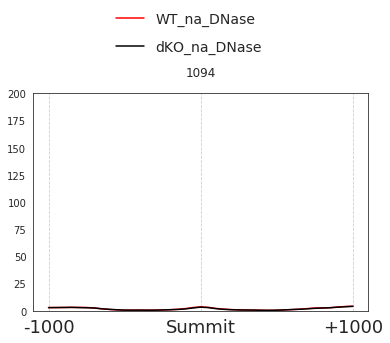

Number of Tags Being Distributed : 5136519
Number of Profiles Being Averaged : 1772
Profile on Sites Summit
....................................................
Number of Tags Being Distributed : 3550994
Number of Profiles Being Averaged : 1772
Profile on Sites Summit
....................................................


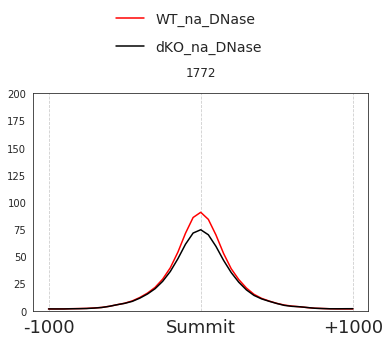

0

In [13]:
resolution=50
window_size=2*resolution
upstreamExtension=1000
downstreamExtension=1000

# DNase

RAW_PATH='/home/xli/cloud_research/PengGroup/XLi/Data/Haihui/CD8-HP/DNase_seq/Bowtie2_Results/Replicates_Included/'
INPUT_read_A_file=RAW_PATH+"WT-na.bedpeisland"

INPUT_read_B_file=RAW_PATH+"dKO-na.bedpeisland"


PATH_Sites_Folder='/home/xli/cloud_research/PengGroup/XLi/Data/Haihui/CD8-HP/DNaseq_seq_RNA_Seq_ChIP_seq_HiC/Features/Diff_DNase/DNase_By_edgeR/Results_From_EdgeR/Naive_Only/'
PATH_Sites=PATH_Sites_Folder+'1094_Tcf1_peaks_with_Tcf7_Core_Motif_hit_NO_DNase.bed'
#'1772_Tcf1_peaks_with_Tcf7_Core_Motif_hit_With_DNase.bed'

profile_and_plot(INPUT_read_A_file, 'WT_na_DNase', 5136519,  INPUT_read_B_file, 'dKO_na_DNase', 3550994,
                 PATH_Sites, resolution, upstreamExtension, downstreamExtension, 200)

PATH_Sites=PATH_Sites_Folder+'1772_Tcf1_peaks_with_Tcf7_Core_Motif_hit_With_DNase.bed'

profile_and_plot(INPUT_read_A_file, 'WT_na_DNase', 5136519,  INPUT_read_B_file, 'dKO_na_DNase', 3550994,
                 PATH_Sites, resolution, upstreamExtension, downstreamExtension, 200)

Number of Tags Being Distributed : 5136519
Number of Profiles Being Averaged : 2043
Profile on Sites Summit
....................................................
Number of Tags Being Distributed : 3550994
Number of Profiles Being Averaged : 2043
Profile on Sites Summit
....................................................


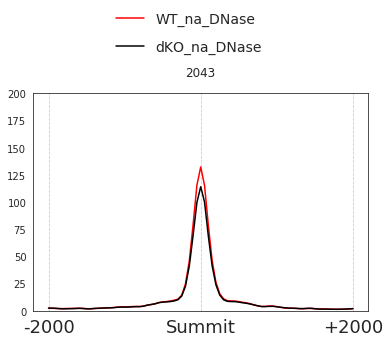

Number of Tags Being Distributed : 5136519
Number of Profiles Being Averaged : 26784
Profile on Sites Summit
....................................................
Number of Tags Being Distributed : 3550994
Number of Profiles Being Averaged : 26784
Profile on Sites Summit
....................................................


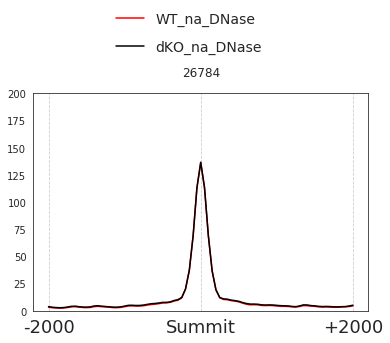

0

In [12]:
resolution=50
window_size=2*resolution
upstreamExtension=2000
downstreamExtension=2000

# DNase

RAW_PATH='/home/xli/cloud_research/PengGroup/XLi/Data/Haihui/CD8-HP/DNase_seq/Bowtie2_Results/Replicates_Included/'
INPUT_read_A_file=RAW_PATH+"WT-na.bedpeisland"

INPUT_read_B_file=RAW_PATH+"dKO-na.bedpeisland"


PATH_Sites_Folder='/home/xli/cloud_research/PengGroup/XLi/Data/Haihui/CD8-HP/DNaseq_seq_RNA_Seq_ChIP_seq_HiC/Features/Diff_DNase/DNase_By_edgeR/Results_From_EdgeR/Naive_Only/'
PATH_Sites=PATH_Sites_Folder+'2043_overlap_28827_union_na_DNase_peaks_5.bed'
#'1772_Tcf1_peaks_with_Tcf7_Core_Motif_hit_With_DNase.bed'

profile_and_plot(INPUT_read_A_file, 'WT_na_DNase', 5136519,  INPUT_read_B_file, 'dKO_na_DNase', 3550994,
                 PATH_Sites, resolution, upstreamExtension, downstreamExtension, 200)

PATH_Sites=PATH_Sites_Folder+'26784_specific_28827_union_na_DNase_peaks_5.bed'

profile_and_plot(INPUT_read_A_file, 'WT_na_DNase', 5136519,  INPUT_read_B_file, 'dKO_na_DNase', 3550994,
                 PATH_Sites, resolution, upstreamExtension, downstreamExtension, 200)

In [5]:
## Customisze

def Get_Boundary_Profile_on_Four(boundary_type, input_tag_file, input_site_file,input_site_file2,input_site_file3,input_site_file4, resolution, window_size, upstreamExtension,downstreamExtension):
    ## Pileup Or
    ga, num_reads = Distribute_By_Pileup(input_tag_file)
    ## Middle Point
    #ga, num_reads = Distribute_By_MiddlePoint(input_tag_file)
##########################################################################################
    ## Read Site file
    site_pos_set = Site_Position_Boundary(input_site_file, boundary_type)
    profile = Get_Profile_At_Point(ga, site_pos_set, resolution, window_size, upstreamExtension, downstreamExtension)
    
    site_pos_set2 = Site_Position_Boundary(input_site_file2, boundary_type)
    profile2 = Get_Profile_At_Point(ga, site_pos_set2, resolution, window_size, upstreamExtension, downstreamExtension)
    
    site_pos_set3 = Site_Position_Boundary(input_site_file3, boundary_type)
    profile3 = Get_Profile_At_Point(ga, site_pos_set3, resolution, window_size, upstreamExtension, downstreamExtension)

    site_pos_set4 = Site_Position_Boundary(input_site_file4, boundary_type)
    profile4 = Get_Profile_At_Point(ga, site_pos_set4, resolution, window_size, upstreamExtension, downstreamExtension)
    
    print "Profile on Site Boundary "+ boundary_type
    print "...................................................."
    return  (profile*(10**9)/(num_reads*len(site_pos_set))), (profile2*(10**9)/(num_reads*len(site_pos_se2t))), (profile3*(10**9)/(num_reads*len(site_pos_set3))), (profile4*(10**9)/(num_reads*len(site_pos_set4)))

Number of Tags Being Distributed : 2602672
Number of Profiles Being Dropped (Length Less than Number of Partitions) : 0
Number of Profiles Being Averaged : 13
Profile on Site Region
Number of Profiles Being Averaged : 13
....................................................
Number of Tags Being Distributed : 1985881
Number of Profiles Being Dropped (Length Less than Number of Partitions) : 0
Number of Profiles Being Averaged : 13
Profile on Site Region
Number of Profiles Being Averaged : 13
....................................................
....................................................
Profile on: 13_SE_WT_up


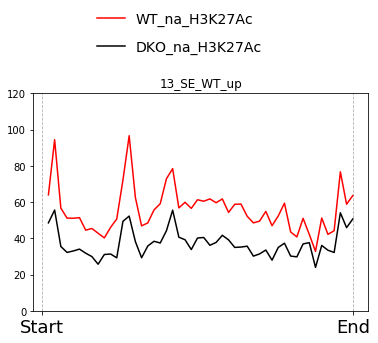

In [16]:
RAW_PATH="/home/lxiang/cloud_research/PengGroup/XLi/Data/Haihui/CD8-HP/DNaseq_seq_RNA_Seq_ChIP_seq_HiC/Features/histone_mark/215_SE/"

PATH_H3K27ac = "/home/lxiang/cloud_research/PengGroup/XLi/Data/Haihui/CD8-HP/DNaseq_seq_RNA_Seq_ChIP_seq_HiC/Features/histone_mark/215_SE/"
Path_WT_na_H3K27Ac = PATH_H3K27ac + 'WT_na_H3K27ac_215_Enhancers.bed'
Path_dKO_na_H3K27Ac_Rep1 = PATH_H3K27ac + 'DKO_na_H3K27ac_215_Enhancers.bed'

Four_Set=[ '13_SE_WT_up', '87_SE_DKO_up', '106_SE_WT_down','9_SE_DKO_down']

NAME= Four_Set[0]

PATH_input_gene_list = RAW_PATH+ NAME +".bed"

genic_partition = 50
norm_profile   = Get_Bed_Region_Profile(Path_WT_na_H3K27Ac, PATH_input_gene_list, genic_partition)#, 63733860+49990079)
norm_profile_2 = Get_Bed_Region_Profile(Path_dKO_na_H3K27Ac_Rep1, PATH_input_gene_list, genic_partition)#, 26537903)

print "...................................................."
print "Profile on: " + NAME

### Plot     
fig, ax=plt.subplots(1,1)
ax.plot(numpy.arange(-genic_partition/2+1, genic_partition/2+1), norm_profile[0:genic_partition], label='WT_na_H3K27Ac',c='r')
ax.plot(numpy.arange(-genic_partition/2+1, genic_partition/2+1), norm_profile_2[0:genic_partition], label='DKO_na_H3K27Ac',c='k')


ax.set_title(NAME)
ax.legend(loc="upper right", bbox_to_anchor=(0.20,1.4,0.5,0),edgecolor='w',
          borderaxespad=0,fancybox=True, shadow=False,  fontsize=14, labelspacing=1.0)
ax.set_ylim(0,120)
x=[-genic_partition/2, genic_partition/2]
ax.set_xticks(x)
customized_xticks=['Start','End']
ax.set_xticklabels(customized_xticks, fontsize=18)
ax.grid(which='major', axis='x', linestyle='--')

Number of Tags Being Distributed : 2602672
Number of Profiles Being Dropped (Length Less than Number of Partitions) : 0
Number of Profiles Being Averaged : 87
Profile on Site Region
Number of Profiles Being Averaged : 87
....................................................
Number of Tags Being Distributed : 1985881
Number of Profiles Being Dropped (Length Less than Number of Partitions) : 0
Number of Profiles Being Averaged : 87
Profile on Site Region
Number of Profiles Being Averaged : 87
....................................................
....................................................
Profile on: 87_SE_DKO_up


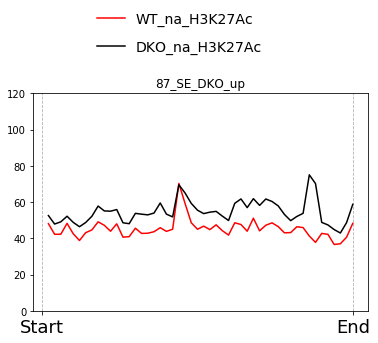

In [15]:
RAW_PATH="/home/lxiang/cloud_research/PengGroup/XLi/Data/Haihui/CD8-HP/DNaseq_seq_RNA_Seq_ChIP_seq_HiC/Features/histone_mark/215_SE/"

PATH_H3K27ac = "/home/lxiang/cloud_research/PengGroup/XLi/Data/Haihui/CD8-HP/DNaseq_seq_RNA_Seq_ChIP_seq_HiC/Features/histone_mark/215_SE/"
Path_WT_na_H3K27Ac = PATH_H3K27ac + 'WT_na_H3K27ac_215_Enhancers.bed'
Path_dKO_na_H3K27Ac_Rep1 = PATH_H3K27ac + 'DKO_na_H3K27ac_215_Enhancers.bed'

Four_Set=[ '13_SE_WT_up', '87_SE_DKO_up', '106_SE_WT_down','9_SE_DKO_down']

NAME= Four_Set[1]

PATH_input_gene_list = RAW_PATH+ NAME +".bed"

genic_partition = 50
norm_profile   = Get_Bed_Region_Profile(Path_WT_na_H3K27Ac, PATH_input_gene_list, genic_partition)#, 63733860+49990079)
norm_profile_2 = Get_Bed_Region_Profile(Path_dKO_na_H3K27Ac_Rep1, PATH_input_gene_list, genic_partition)#, 26537903)

print "...................................................."
print "Profile on: " + NAME

### Plot     
fig, ax=plt.subplots(1,1)
ax.plot(numpy.arange(-genic_partition/2+1, genic_partition/2+1), norm_profile[0:genic_partition], label='WT_na_H3K27Ac',c='r')
ax.plot(numpy.arange(-genic_partition/2+1, genic_partition/2+1), norm_profile_2[0:genic_partition], label='DKO_na_H3K27Ac',c='k')


ax.set_title(NAME)
ax.legend(loc="upper right", bbox_to_anchor=(0.20,1.4,0.5,0),edgecolor='w',
          borderaxespad=0,fancybox=True, shadow=False,  fontsize=14, labelspacing=1.0)
ax.set_ylim(0,120)
x=[-genic_partition/2, genic_partition/2]
ax.set_xticks(x)
customized_xticks=['Start','End']
ax.set_xticklabels(customized_xticks, fontsize=18)
ax.grid(which='major', axis='x', linestyle='--')

Number of Tags Being Distributed : 2602672
Number of Profiles Being Dropped (Length Less than Number of Partitions) : 0
Number of Profiles Being Averaged : 106
Profile on Site Region
Number of Profiles Being Averaged : 106
....................................................
Number of Tags Being Distributed : 1985881
Number of Profiles Being Dropped (Length Less than Number of Partitions) : 0
Number of Profiles Being Averaged : 106
Profile on Site Region
Number of Profiles Being Averaged : 106
....................................................
....................................................
Profile on: 106_SE_WT_down


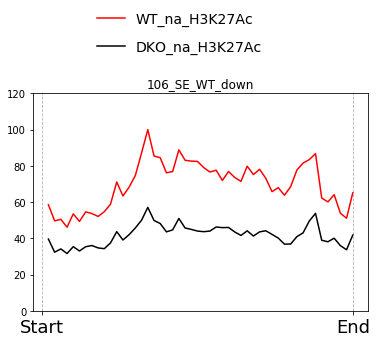

In [14]:
RAW_PATH="/home/lxiang/cloud_research/PengGroup/XLi/Data/Haihui/CD8-HP/DNaseq_seq_RNA_Seq_ChIP_seq_HiC/Features/histone_mark/215_SE/"

PATH_H3K27ac = "/home/lxiang/cloud_research/PengGroup/XLi/Data/Haihui/CD8-HP/DNaseq_seq_RNA_Seq_ChIP_seq_HiC/Features/histone_mark/215_SE/"
Path_WT_na_H3K27Ac = PATH_H3K27ac + 'WT_na_H3K27ac_215_Enhancers.bed'
Path_dKO_na_H3K27Ac_Rep1 = PATH_H3K27ac + 'DKO_na_H3K27ac_215_Enhancers.bed'

Four_Set=[ '13_SE_WT_up', '87_SE_DKO_up', '106_SE_WT_down','9_SE_DKO_down']

NAME= Four_Set[2]

PATH_input_gene_list = RAW_PATH+ NAME +".bed"

genic_partition = 50
norm_profile   = Get_Bed_Region_Profile(Path_WT_na_H3K27Ac, PATH_input_gene_list, genic_partition)#, 63733860+49990079)
norm_profile_2 = Get_Bed_Region_Profile(Path_dKO_na_H3K27Ac_Rep1, PATH_input_gene_list, genic_partition)#, 26537903)

print "...................................................."
print "Profile on: " + NAME

### Plot     
fig, ax=plt.subplots(1,1)
ax.plot(numpy.arange(-genic_partition/2+1, genic_partition/2+1), norm_profile[0:genic_partition], label='WT_na_H3K27Ac',c='r')
ax.plot(numpy.arange(-genic_partition/2+1, genic_partition/2+1), norm_profile_2[0:genic_partition], label='DKO_na_H3K27Ac',c='k')


ax.set_title(NAME)
ax.legend(loc="upper right", bbox_to_anchor=(0.20,1.4,0.5,0),edgecolor='w',
          borderaxespad=0,fancybox=True, shadow=False,  fontsize=14, labelspacing=1.0)
ax.set_ylim(0,120)
x=[-genic_partition/2, genic_partition/2]
ax.set_xticks(x)
customized_xticks=['Start','End']
ax.set_xticklabels(customized_xticks, fontsize=18)
ax.grid(which='major', axis='x', linestyle='--')

....................................................
Profile on: 9_SE_DKO_down


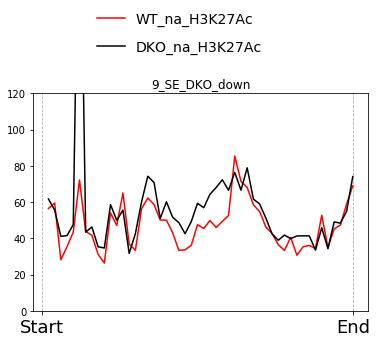

In [13]:
RAW_PATH="/home/lxiang/cloud_research/PengGroup/XLi/Data/Haihui/CD8-HP/DNaseq_seq_RNA_Seq_ChIP_seq_HiC/Features/histone_mark/215_SE/"

PATH_H3K27ac = "/home/lxiang/cloud_research/PengGroup/XLi/Data/Haihui/CD8-HP/DNaseq_seq_RNA_Seq_ChIP_seq_HiC/Features/histone_mark/215_SE/"
Path_WT_na_H3K27Ac = PATH_H3K27ac + 'WT_na_H3K27ac_215_Enhancers.bed'
Path_dKO_na_H3K27Ac_Rep1 = PATH_H3K27ac + 'DKO_na_H3K27ac_215_Enhancers.bed'

Four_Set=[ '13_SE_WT_up', '87_SE_DKO_up', '106_SE_WT_down','9_SE_DKO_down']

NAME= Four_Set[3]

PATH_input_gene_list = RAW_PATH+ NAME +".bed"

genic_partition = 50
#norm_profile   = Get_Bed_Region_Profile(Path_WT_na_H3K27Ac, PATH_input_gene_list, genic_partition)#, 63733860+49990079)
#norm_profile_2 = Get_Bed_Region_Profile(Path_dKO_na_H3K27Ac_Rep1, PATH_input_gene_list, genic_partition)#, 26537903)

print "...................................................."
print "Profile on: " + NAME

### Plot     
fig, ax=plt.subplots(1,1)
ax.plot(numpy.arange(-genic_partition/2+1, genic_partition/2+1), norm_profile[0:genic_partition], label='WT_na_H3K27Ac',c='r')
ax.plot(numpy.arange(-genic_partition/2+1, genic_partition/2+1), norm_profile_2[0:genic_partition], label='DKO_na_H3K27Ac',c='k')


ax.set_title(NAME)
ax.legend(loc="upper right", bbox_to_anchor=(0.20,1.4,0.5,0),edgecolor='w',
          borderaxespad=0,fancybox=True, shadow=False,  fontsize=14, labelspacing=1.0)
ax.set_ylim(0,120)
x=[-genic_partition/2, genic_partition/2]
ax.set_xticks(x)
customized_xticks=['Start','End']
ax.set_xticklabels(customized_xticks, fontsize=18)
ax.grid(which='major', axis='x', linestyle='--')

Number of Tags Being Distributed : 62534675
Number of Profiles Being Averaged : 25
Profile on Site Boundary TSS
....................................................
Number of Tags Being Distributed : 26537903
Number of Profiles Being Averaged : 25
Profile on Site Boundary TSS
....................................................
....................................................
Profile on: 25_SE_DKO_down


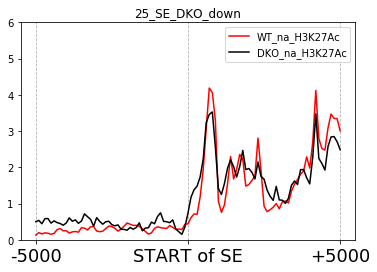

In [44]:
# Boundary Profile
boundary_type='TSS'

resolution = 100
upstreamExtension = 5000
num_profile_points= 2*upstreamExtension / resolution +1
window_size = resolution

norm_profile_TSS   = Get_Boundary_Profile(boundary_type, Path_WT_na_H3K27Ac_Rep1, PATH_input_gene_list, resolution, window_size, upstreamExtension,upstreamExtension)
norm_profile2_TSS   = Get_Boundary_Profile(boundary_type, Path_dKO_na_H3K27Ac_Rep1, PATH_input_gene_list, resolution, window_size, upstreamExtension,upstreamExtension)
print "...................................................."
print "Profile on: " + NAME

### Plot     
fig, ax=plt.subplots(1,1)
ax.plot(numpy.arange(-(num_profile_points-1)/2,(num_profile_points+1)/2), norm_profile_TSS[0:num_profile_points], label='WT_na_H3K27Ac',c='r')
ax.plot(numpy.arange(-(num_profile_points-1)/2,(num_profile_points+1)/2), norm_profile2_TSS[0:num_profile_points], label='DKO_na_H3K27Ac',c='k')

ax.set_title(NAME)
ax.legend()
ax.set_ylim(0,6)
x=[-upstreamExtension / resolution,0,upstreamExtension /resolution ]
ax.set_xticks(x)
customized_xticks=['-'+str(upstreamExtension),'START of SE','+'+str(upstreamExtension)]
ax.set_xticklabels(customized_xticks, fontsize=18)
ax.grid(which='major', axis='x', linestyle='--')
#ax.grid(True)

Number of Tags Being Distributed : 28556143
Number of Profiles Being Averaged : 25
Profile on Site Boundary TES
....................................................
Number of Tags Being Distributed : 26537903
Number of Profiles Being Averaged : 25
Profile on Site Boundary TES
....................................................
....................................................
Profile on: 25_SE_DKO_down


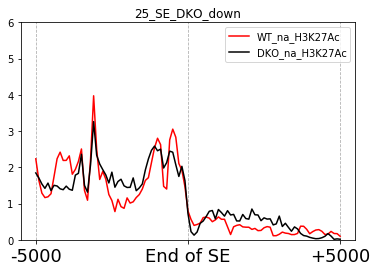

In [45]:
# Boundary Profile
Path_WT_na_H3K27Ac_Rep1 ="/home/lxiang/cloud_research/PengGroup/XLi/Data/Haihui/CD8-HP/ChIP_seq/histone_mark/H3K27Ac/SICER_Results/WT-na-H3K27Ac-Rep1/WT-na-H3K27Ac-Rep1.sg-W200-G400-FDR0.05-islandfiltered.bed"
Path_dKO_na_H3K27Ac_Rep1 ="/home/lxiang/cloud_research/PengGroup/XLi/Data/Haihui/CD8-HP/ChIP_seq/histone_mark/H3K27Ac/SICER_Results/dKO-na-H3K27Ac-Rep1/dKO-na-H3K27Ac-Rep1.sg-W200-G400-FDR0.05-islandfiltered.bed"
con1_name="WT_na_H3K27Ac"
con2_name="DKO_na_H3K27Ac"

boundary_type='TES'

resolution = 100
upstreamExtension = 5000
num_profile_points= 2*upstreamExtension / resolution +1
window_size = resolution

norm_profile_TES   = Get_Boundary_Profile(boundary_type, Path_WT_na_H3K27Ac_Rep1, PATH_input_gene_list, resolution, window_size, upstreamExtension,upstreamExtension)
norm_profile2_TES   = Get_Boundary_Profile(boundary_type, Path_dKO_na_H3K27Ac_Rep1, PATH_input_gene_list, resolution, window_size, upstreamExtension,upstreamExtension)
print "...................................................."
print "Profile on: " + NAME

### Plot     
fig, ax=plt.subplots(1,1)
ax.plot(numpy.arange(-(num_profile_points-1)/2,(num_profile_points+1)/2), norm_profile_TES[0:num_profile_points], label=con1_name,c='r')
ax.plot(numpy.arange(-(num_profile_points-1)/2,(num_profile_points+1)/2), norm_profile2_TES[0:num_profile_points], label=con2_name,c='k')

ax.set_title(NAME)
ax.legend()
ax.set_ylim(0,6)
x=[-upstreamExtension / resolution,0,upstreamExtension /resolution ]
ax.set_xticks(x)
customized_xticks=['-'+str(upstreamExtension),'End of SE','+'+str(upstreamExtension)]
ax.set_xticklabels(customized_xticks, fontsize=18)
ax.grid(which='major', axis='x', linestyle='--')
#ax.grid(True)

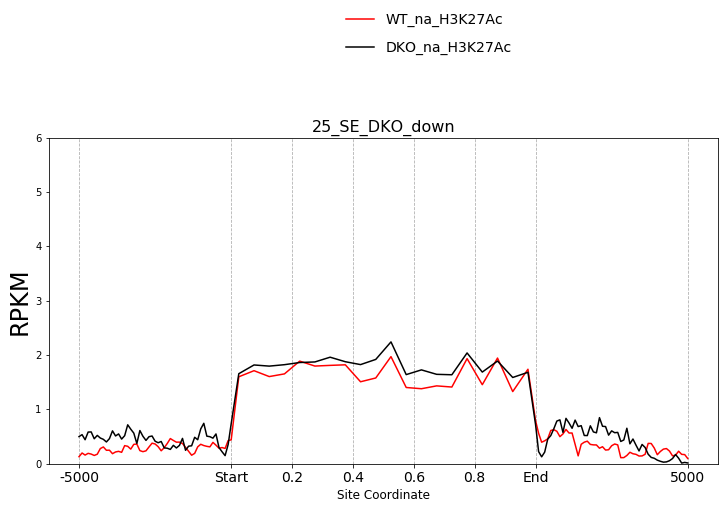

In [46]:
def profile_Up_genebody_Down_site(upstream_profile, site_body_profile, downstream_profile, upstream_profile2, site_body_profile2, downstream_profile2, resolution, genic_partition,
                                  upstreamExtension, downstreamExtension, genes_set_name, site_name, con_name,con_name2):
##########################################################################################    
    upstream_xValues = numpy.arange(0, upstreamExtension + 1, resolution)[-1::-1] * (-1)
#########################################################################################
    downstream_xValues = numpy.arange(0, downstreamExtension + 1, resolution)
##########################################################################################
    site_body_xValues = [0.0] * genic_partition
    for i in xrange(genic_partition):
        site_body_xValues[i] = (i + 0.5) / genic_partition
    ### Plot     
    numTicksInBody = 5

    upstream_scale = 0.5
    upstream_scaled_xValues = [numTicksInBody * upstream_scale * (1 + item * 1.0 / upstreamExtension) for item in
                               upstream_xValues]

    site_body_scaled_xValues = [numTicksInBody * upstream_scale + item * numTicksInBody for item in
                                site_body_xValues]

    downstream_scale = 0.5
    downstream_scaled_xValues = [
        numTicksInBody * upstream_scale + numTicksInBody + numTicksInBody * downstream_scale * item * 1.0 / downstreamExtension
        for item in downstream_xValues]

    xValues = upstream_scaled_xValues + site_body_scaled_xValues + downstream_scaled_xValues
    
    profile = numpy.append(upstream_profile[0:upstreamExtension/resolution+1], site_body_profile)
    profile = numpy.append(profile, downstream_profile[downstreamExtension/resolution:])
    
    profile2 = numpy.append(upstream_profile2[0:upstreamExtension/resolution+1], site_body_profile2)
    profile2 = numpy.append(profile2, downstream_profile2[downstreamExtension/resolution:])
    
#    profile3 = numpy.append(upstream_profile3[0:upstreamExtension/resolution+1], site_body_profile3)
#    profile3 = numpy.append(profile3, downstream_profile3[downstreamExtension/resolution:])

    xticks_subset = [0] * (numTicksInBody + 1)
    xticklabels_subset = [0] * (numTicksInBody + 1)
    for i in xrange(numTicksInBody + 1):
        xticks_subset[i] = numTicksInBody * upstream_scale + i
        if i == 0:
            xticklabels_subset[i] = 'Start'
        elif i == numTicksInBody:
            xticklabels_subset[i] = 'End'
        else:
            xticklabels_subset[i] = str(i * 1.0 / numTicksInBody)

    xticks = [0] + xticks_subset + [xticks_subset[-1] + numTicksInBody * downstream_scale]
    xticklabels = [ '-'+str(upstreamExtension)] + xticklabels_subset + [
        str(downstreamExtension)]


    fig, ax=plt.subplots(1,1, figsize=(12,6))
    
    ax.plot(xValues, profile, label=con_name, c="r")
    ax.plot(xValues, profile2, label=con_name2, c="k")
#    ax.plot(xValues, profile3, label=con_name3)
    
    ax.grid(which='major', axis='x', linestyle='--')
    ax.set_title(genes_set_name, fontsize=16)
    ax.set_xlabel('Site Coordinate', fontsize=12)
    ax.legend()
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels, fontsize=14)
    ax.set_ylabel('RPKM', fontsize=24)
    fig_name='Profile-SiteBody-'+genes_set_name+'_'+con_name
    plt.savefig(fig_name + '.png', format='png')
    ax.set_ylim(0,6)
    ax.legend(loc="upper right", bbox_to_anchor=(0.20,1.4,0.5,0),edgecolor='w',
          borderaxespad=0,fancybox=True, shadow=False,  fontsize=14, labelspacing=1.0)
    return None

genes_set_name=NAME
site_name=NAME
con1_name="WT_na_H3K27Ac"
con2_name="DKO_na_H3K27Ac"
profile_Up_genebody_Down_site(norm_profile_TSS, norm_profile, norm_profile_TES, norm_profile2_TSS, norm_profile_2, norm_profile2_TES,
            resolution, genic_partition,  upstreamExtension, upstreamExtension, genes_set_name, site_name, con1_name, con2_name)

In [30]:
## One Cycle Completed

Number of Tags Being Distributed : 3050942
Number of Profiles Being Dropped (Length Less than Number of Partitions) : 0
Number of Profiles Being Averaged : 1297
Profile on Site Region
Number of Profiles Being Averaged : 1297
....................................................
Number of Tags Being Distributed : 2670838
Number of Profiles Being Dropped (Length Less than Number of Partitions) : 0
Number of Profiles Being Averaged : 1297
Profile on Site Region
Number of Profiles Being Averaged : 1297
....................................................


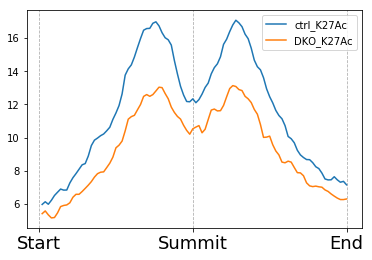

In [12]:
# pileup
INPUT_read_file = '/home/lxiang/cloud_research/PengGroup/XLi/Data/Haihui/CD8-HP/ChIP_seq/histone_mark/SICER_Results/ctrl_CD8_K27Ac/ctrl_CD8_K27Ac_Dup_Simple_Repeats_Removed-W20-G400-FDR0.05-islandfiltered.bed'

INPUT_read_file_2 ="/home/lxiang/cloud_research/PengGroup/XLi/Data/Haihui/CD8-HP/ChIP_seq/histone_mark/SICER_Results/dKO_CD8_K27Ac/dKO_CD8_K27Ac_Dup_Simple_Repeats_Removed-W20-G400-FDR0.05-islandfiltered.bed"


INPUT_gene_list="/home/lxiang/cloud_research/PengGroup/XLi/Data/Haihui/CD8-HP/ChIP_seq/histone_mark/SICER_Results/1297_Tcf1_Motif_+_Union_peak_ex1000.bed"

genic_partition = 100

norm_profile   = Get_Bed_Region_Profile(INPUT_read_file, INPUT_gene_list, genic_partition)
norm_profile2   = Get_Bed_Region_Profile(INPUT_read_file_2, INPUT_gene_list, genic_partition)
### Plot     
fig, ax=plt.subplots(1,1)
ax.plot(numpy.arange(-genic_partition/2+1, genic_partition/2+1), norm_profile[0:genic_partition], label='ctrl_K27Ac')
ax.plot(numpy.arange(-genic_partition/2+1, genic_partition/2+1), norm_profile2[0:genic_partition], label='DKO_K27Ac')

ax.legend()
#ax.set_ylim(0,30)
x=[-genic_partition/2, 0, genic_partition/2]
ax.set_xticks(x)
customized_xticks=['Start','Middle Point','End']
ax.set_xticklabels(customized_xticks, fontsize=18)
ax.grid(which='major', axis='x', linestyle='--')

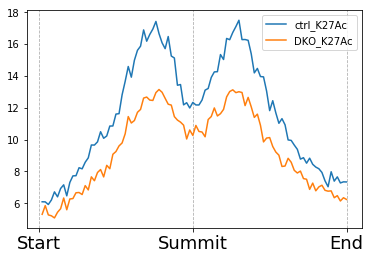

In [9]:
## middle point 
INPUT_read_file = '/home/lxiang/cloud_research/PengGroup/XLi/Data/Haihui/CD8-HP/ChIP_seq/histone_mark/SICER_Results/ctrl_CD8_K27Ac/ctrl_CD8_K27Ac_Dup_Simple_Repeats_Removed-W20-G400-FDR0.05-islandfiltered.bed'

INPUT_read_file_2 ="/home/lxiang/cloud_research/PengGroup/XLi/Data/Haihui/CD8-HP/ChIP_seq/histone_mark/SICER_Results/dKO_CD8_K27Ac/dKO_CD8_K27Ac_Dup_Simple_Repeats_Removed-W20-G400-FDR0.05-islandfiltered.bed"


INPUT_gene_list="/home/lxiang/cloud_research/PengGroup/XLi/Data/Haihui/CD8-HP/ChIP_seq/histone_mark/SICER_Results/1297_Tcf1_Motif_+_Union_peak_ex1000.bed"

genic_partition = 100

#norm_profile   = Get_Bed_Region_Profile(INPUT_read_file, INPUT_gene_list, genic_partition)
#norm_profile2   = Get_Bed_Region_Profile(INPUT_read_file_2, INPUT_gene_list, genic_partition)
### Plot     
fig, ax=plt.subplots(1,1)
ax.plot(numpy.arange(-genic_partition/2+1, genic_partition/2+1), norm_profile[0:genic_partition], label='ctrl_K27Ac')
ax.plot(numpy.arange(-genic_partition/2+1, genic_partition/2+1), norm_profile2[0:genic_partition], label='DKO_K27Ac')

ax.legend()
#ax.set_ylim(0,30)
x=[-genic_partition/2, 0, genic_partition/2]
ax.set_xticks(x)
customized_xticks=['Start','Middle Point','End']
ax.set_xticklabels(customized_xticks, fontsize=18)
ax.grid(which='major', axis='x', linestyle='--')

Number of Tags Being Distributed : 3050942
Number of Profiles Being Averaged : 1297
Profile on Sites Summit 
....................................................
Number of Tags Being Distributed : 2670838
Number of Profiles Being Averaged : 1297
Profile on Sites Summit 
....................................................


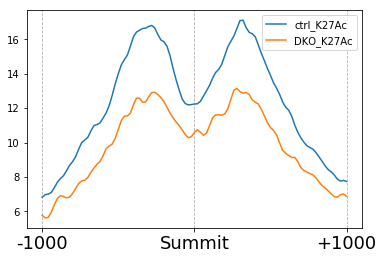

In [13]:
# pileup

INPUT_read_file = '/home/lxiang/cloud_research/PengGroup/XLi/Data/Haihui/CD8-HP/ChIP_seq/histone_mark/SICER_Results/ctrl_CD8_K27Ac/ctrl_CD8_K27Ac_Dup_Simple_Repeats_Removed-W20-G400-FDR0.05-islandfiltered.bed'

INPUT_read_file_2 ="/home/lxiang/cloud_research/PengGroup/XLi/Data/Haihui/CD8-HP/ChIP_seq/histone_mark/SICER_Results/dKO_CD8_K27Ac/dKO_CD8_K27Ac_Dup_Simple_Repeats_Removed-W20-G400-FDR0.05-islandfiltered.bed"


INPUT_gene_list="/home/lxiang/cloud_research/PengGroup/XLi/Data/Haihui/CD8-HP/ChIP_seq/histone_mark/SICER_Results/1297_Tcf1_Motif_+_Union_peak_For_HTseq.bed"

resolution = 20
upstreamExtension = 1000
num_profile_points= 2*upstreamExtension / resolution +1
window_size = 2*resolution
norm_profile   = Get_Summit_Profile(INPUT_read_file, INPUT_gene_list, resolution, window_size, upstreamExtension, upstreamExtension)
norm_profile2   = Get_Summit_Profile(INPUT_read_file_2, INPUT_gene_list, resolution, window_size, upstreamExtension, upstreamExtension)



### Plot     
fig, ax=plt.subplots(1,1)

ax.plot(numpy.arange(-(num_profile_points-1)/2,(num_profile_points+1)/2), norm_profile[0:num_profile_points], label='ctrl_K27Ac')
ax.plot(numpy.arange(-(num_profile_points-1)/2,(num_profile_points+1)/2), norm_profile2[0:num_profile_points], label='DKO_K27Ac')


ax.legend()
#ax.set_ylim(0,30)
x=[-upstreamExtension / resolution,0,upstreamExtension /resolution ]
ax.set_xticks(x)
customized_xticks=['-'+str(upstreamExtension),'Middle Point','+'+str(upstreamExtension)]
ax.set_xticklabels(customized_xticks, fontsize=18)
ax.grid(which='major', axis='x', linestyle='--')

Number of Tags Being Distributed : 3050942
Number of Profiles Being Averaged : 1297
Profile on Sites Summit 
....................................................
Number of Tags Being Distributed : 2670838
Number of Profiles Being Averaged : 1297
Profile on Sites Summit 
....................................................


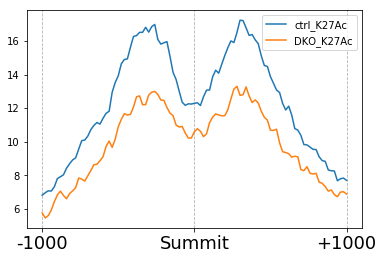

In [7]:
#middle point 

INPUT_read_file = '/home/lxiang/cloud_research/PengGroup/XLi/Data/Haihui/CD8-HP/ChIP_seq/histone_mark/SICER_Results/ctrl_CD8_K27Ac/ctrl_CD8_K27Ac_Dup_Simple_Repeats_Removed-W20-G400-FDR0.05-islandfiltered.bed'

INPUT_read_file_2 ="/home/lxiang/cloud_research/PengGroup/XLi/Data/Haihui/CD8-HP/ChIP_seq/histone_mark/SICER_Results/dKO_CD8_K27Ac/dKO_CD8_K27Ac_Dup_Simple_Repeats_Removed-W20-G400-FDR0.05-islandfiltered.bed"


INPUT_gene_list="/home/lxiang/cloud_research/PengGroup/XLi/Data/Haihui/CD8-HP/ChIP_seq/histone_mark/SICER_Results/1297_Tcf1_Motif_+_Union_peak_For_HTseq.bed"

resolution = 20
upstreamExtension = 1000
num_profile_points= 2*upstreamExtension / resolution +1
window_size = 2*resolution
norm_profile   = Get_Summit_Profile(INPUT_read_file, INPUT_gene_list, resolution, window_size, upstreamExtension, upstreamExtension)
norm_profile2   = Get_Summit_Profile(INPUT_read_file_2, INPUT_gene_list, resolution, window_size, upstreamExtension, upstreamExtension)



### Plot     
fig, ax=plt.subplots(1,1)

ax.plot(numpy.arange(-(num_profile_points-1)/2,(num_profile_points+1)/2), norm_profile[0:num_profile_points], label='ctrl_K27Ac')
ax.plot(numpy.arange(-(num_profile_points-1)/2,(num_profile_points+1)/2), norm_profile2[0:num_profile_points], label='DKO_K27Ac')


ax.legend()
#ax.set_ylim(0,30)
x=[-upstreamExtension / resolution,0,upstreamExtension /resolution ]
ax.set_xticks(x)
customized_xticks=['-'+str(upstreamExtension),'Middle Point','+'+str(upstreamExtension)]
ax.set_xticklabels(customized_xticks, fontsize=18)
ax.grid(which='major', axis='x', linestyle='--')



Number of Tags Being Distributed : 100035
Number of Profiles Being Dropped (Length Less than Number of Partitions) : 1224
Number of Profiles Being Averaged : 17144
Profile on Site Region
Number of Profiles Being Averaged : 17144
....................................................
Number of Tags Being Distributed : 112488
Number of Profiles Being Dropped (Length Less than Number of Partitions) : 1224
Number of Profiles Being Averaged : 17144
Profile on Site Region
Number of Profiles Being Averaged : 17144
....................................................
Number of Tags Being Distributed : 18368
Number of Profiles Being Dropped (Length Less than Number of Partitions) : 1224
Number of Profiles Being Averaged : 17144
Profile on Site Region
Number of Profiles Being Averaged : 17144
....................................................
....................................................
Profile on: TSS_3'UTR_TES 


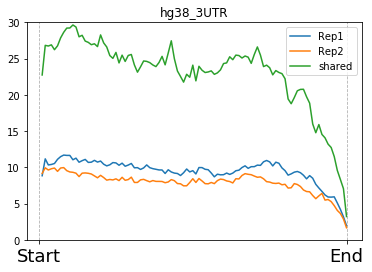

In [95]:
# Region Profile
PATH_FOLDER="/home/lxiang/cloud_research/PengGroup/XLi/Data/Haihui/CD8-HP/DNaseq_seq_RNA_Seq_ChIP_seq_HiC/Features/histone_mark/super_enhancer/"
INPUT_read_file = PATH_FOLDER+ 'WT_na_H3K27Ac_for_SuperEnhancer_plot.bed'
INPUT_read_file2 = PATH_FOLDER+ 'dKO_na_H3K27Ac_Rep1_for_SuperEnhancer_plot.bed'

PATH_FOLDER='/home/lxiang/cloud_research/PengGroup/XLi/Data/Intron_Retention/TianYi/Profile/'

Gene_Name='hg38_3UTR.bed'

INPUT_gene_list = PATH_FOLDER + Gene_Name

genic_partition = 100
norm_profile   = Get_Bed_Region_Profile(INPUT_read_file, INPUT_gene_list, genic_partition)
norm_profile_2 = Get_Bed_Region_Profile(INPUT_read_file2, INPUT_gene_list, genic_partition)
norm_profile_3 = Get_Bed_Region_Profile(INPUT_read_file3, INPUT_gene_list, genic_partition)

print "...................................................."
print "Profile on: TSS_3'UTR_TES "

### Plot     
fig, ax=plt.subplots(1,1)
ax.plot(numpy.arange(-genic_partition/2+1, genic_partition/2+1), norm_profile[0:genic_partition], label='Rep1')
ax.plot(numpy.arange(-genic_partition/2+1, genic_partition/2+1), norm_profile_2[0:genic_partition], label='Rep2')
ax.plot(numpy.arange(-genic_partition/2+1, genic_partition/2+1), norm_profile_3[0:genic_partition], label='shared')


ax.set_title(Gene_Name[:-4])
ax.legend()
ax.set_ylim(0,30)
x=[-genic_partition/2, genic_partition/2]
ax.set_xticks(x)
customized_xticks=['Start','End']
ax.set_xticklabels(customized_xticks, fontsize=18)
ax.grid(which='major', axis='x', linestyle='--')

Number of Tags Being Distributed : 100035
Number of Profiles Being Averaged : 18330
Profile on Site Boundary TES
....................................................
....................................................
Profile on: TSS_3'UTR_TES 


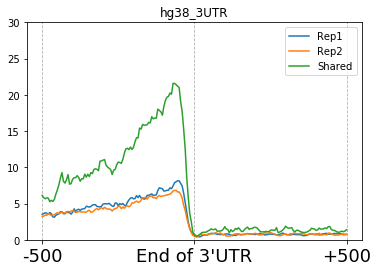

In [94]:
# Region Profile
PATH_FOLDER='/home/lxiang/cloud_research/PengGroup/XLi/Data/Intron_Retention/TianYi/Profile/'
INPUT_read_file = PATH_FOLDER+'/'+"Rep1.bed"
INPUT_read_file2 = PATH_FOLDER+'/'+"Rep2.bed"
INPUT_read_file3 = PATH_FOLDER+'/'+"18368_common_peaks.bed"


PATH_FOLDER='/home/lxiang/cloud_research/PengGroup/XLi/Data/Intron_Retention/TianYi/Profile/'

Gene_Name='hg38_3UTR.bed'

INPUT_gene_list = PATH_FOLDER + Gene_Name
boundary_type='TES'

resolution = 5
upstreamExtension = 500
num_profile_points= 2*upstreamExtension / resolution +1
window_size = resolution

norm_profile_TES   = Get_Boundary_Profile(boundary_type, INPUT_read_file, INPUT_gene_list, resolution, window_size, upstreamExtension,upstreamExtension)
norm_profile2_TES   = Get_Boundary_Profile(boundary_type, INPUT_read_file2, INPUT_gene_list, resolution, window_size, upstreamExtension,upstreamExtension)
norm_profile3_TES   = Get_Boundary_Profile(boundary_type, INPUT_read_file3, INPUT_gene_list, resolution, window_size, upstreamExtension,upstreamExtension)
print "...................................................."
print "Profile on: TSS_3'UTR_TES "

### Plot     
fig, ax=plt.subplots(1,1)
ax.plot(numpy.arange(-(num_profile_points-1)/2,(num_profile_points+1)/2), norm_profile_TES[0:num_profile_points], label='Rep1')
ax.plot(numpy.arange(-(num_profile_points-1)/2,(num_profile_points+1)/2), norm_profile2_TES[0:num_profile_points], label='Rep2')
ax.plot(numpy.arange(-(num_profile_points-1)/2,(num_profile_points+1)/2), norm_profile3_TES[0:num_profile_points], label='Shared')


ax.set_title(Gene_Name[:-4])
ax.legend()
ax.set_ylim(0,30)
x=[-upstreamExtension / resolution,0,upstreamExtension /resolution ]
ax.set_xticks(x)
customized_xticks=['-'+str(upstreamExtension),'End of 3\'UTR','+'+str(upstreamExtension)]
ax.set_xticklabels(customized_xticks, fontsize=18)
ax.grid(which='major', axis='x', linestyle='--')
#ax.grid(True)

Number of Tags Being Distributed : 100035
Number of Profiles Being Averaged : 18335
Profile on Site Boundary TSS
....................................................
Number of Tags Being Distributed : 112488
Number of Profiles Being Averaged : 18335
Profile on Site Boundary TSS
....................................................
Number of Tags Being Distributed : 18368
Number of Profiles Being Averaged : 18335
Profile on Site Boundary TSS
....................................................
....................................................
Profile on: TSS_3'UTR_TES 


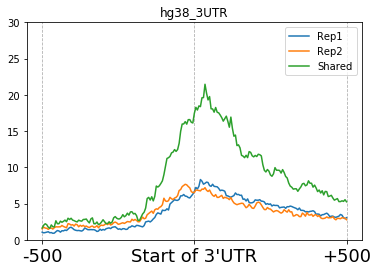

In [93]:
# Region Profile
PATH_FOLDER='/home/lxiang/cloud_research/PengGroup/XLi/Data/Intron_Retention/TianYi/Profile/'
INPUT_read_file = PATH_FOLDER+'/'+"Rep1.bed"
INPUT_read_file2 = PATH_FOLDER+'/'+"Rep2.bed"
INPUT_read_file3 = PATH_FOLDER+'/'+"18368_common_peaks.bed"


PATH_FOLDER='/home/lxiang/cloud_research/PengGroup/XLi/Data/Intron_Retention/TianYi/Profile/'

Gene_Name='hg38_3UTR.bed'

INPUT_gene_list = PATH_FOLDER + Gene_Name
boundary_type='TSS'

resolution = 5
upstreamExtension = 500
num_profile_points= 2*upstreamExtension / resolution +1
window_size = resolution

norm_profile_TSS   = Get_Boundary_Profile(boundary_type, INPUT_read_file, INPUT_gene_list, resolution, window_size, upstreamExtension,upstreamExtension)
norm_profile2_TSS   = Get_Boundary_Profile(boundary_type, INPUT_read_file2, INPUT_gene_list, resolution, window_size, upstreamExtension,upstreamExtension)
norm_profile3_TSS   = Get_Boundary_Profile(boundary_type, INPUT_read_file3, INPUT_gene_list, resolution, window_size, upstreamExtension,upstreamExtension)
print "...................................................."
print "Profile on: TSS_3'UTR_TES "

### Plot     
fig, ax=plt.subplots(1,1)
ax.plot(numpy.arange(-(num_profile_points-1)/2,(num_profile_points+1)/2), norm_profile_TSS[0:num_profile_points], label='Rep1')
ax.plot(numpy.arange(-(num_profile_points-1)/2,(num_profile_points+1)/2), norm_profile2_TSS[0:num_profile_points], label='Rep2')
ax.plot(numpy.arange(-(num_profile_points-1)/2,(num_profile_points+1)/2), norm_profile3_TSS[0:num_profile_points], label='Shared')


ax.set_title(Gene_Name[:-4])
ax.legend()
ax.set_ylim(0,30)
x=[-upstreamExtension / resolution,0,upstreamExtension /resolution ]
ax.set_xticks(x)
customized_xticks=['-'+str(upstreamExtension),'Start of 3\'UTR','+'+str(upstreamExtension)]
ax.set_xticklabels(customized_xticks, fontsize=18)
ax.grid(which='major', axis='x', linestyle='--')
#ax.grid(True)

In [99]:
def profile_Up_genebody_Down_site(upstream_profile, site_body_profile, downstream_profile, upstream_profile2, site_body_profile2, downstream_profile2,upstream_profile3, site_body_profile3, downstream_profile3, resolution, genic_partition,
                                  upstreamExtension, downstreamExtension, genes_set_name, site_name, con_name,con_name2,con_name3):
##########################################################################################    
    upstream_xValues = numpy.arange(0, upstreamExtension + 1, resolution)[-1::-1] * (-1)
#########################################################################################
    downstream_xValues = numpy.arange(0, downstreamExtension + 1, resolution)
##########################################################################################
    site_body_xValues = [0.0] * genic_partition
    for i in xrange(genic_partition):
        site_body_xValues[i] = (i + 0.5) / genic_partition
    ### Plot     
    numTicksInBody = 5

    upstream_scale = 0.5
    upstream_scaled_xValues = [numTicksInBody * upstream_scale * (1 + item * 1.0 / upstreamExtension) for item in
                               upstream_xValues]

    site_body_scaled_xValues = [numTicksInBody * upstream_scale + item * numTicksInBody for item in
                                site_body_xValues]

    downstream_scale = 0.5
    downstream_scaled_xValues = [
        numTicksInBody * upstream_scale + numTicksInBody + numTicksInBody * downstream_scale * item * 1.0 / downstreamExtension
        for item in downstream_xValues]

    xValues = upstream_scaled_xValues + site_body_scaled_xValues + downstream_scaled_xValues
    
    profile = numpy.append(upstream_profile[0:upstreamExtension/resolution+1], site_body_profile)
    profile = numpy.append(profile, downstream_profile[downstreamExtension/resolution:])
    
    profile2 = numpy.append(upstream_profile2[0:upstreamExtension/resolution+1], site_body_profile2)
    profile2 = numpy.append(profile2, downstream_profile2[downstreamExtension/resolution:])
    
    profile3 = numpy.append(upstream_profile3[0:upstreamExtension/resolution+1], site_body_profile3)
    profile3 = numpy.append(profile3, downstream_profile3[downstreamExtension/resolution:])

    xticks_subset = [0] * (numTicksInBody + 1)
    xticklabels_subset = [0] * (numTicksInBody + 1)
    for i in xrange(numTicksInBody + 1):
        xticks_subset[i] = numTicksInBody * upstream_scale + i
        if i == 0:
            xticklabels_subset[i] = 'Start'
        elif i == numTicksInBody:
            xticklabels_subset[i] = 'End'
        else:
            xticklabels_subset[i] = str(i * 1.0 / numTicksInBody)

    xticks = [0] + xticks_subset + [xticks_subset[-1] + numTicksInBody * downstream_scale]
    xticklabels = [ '-'+str(upstreamExtension)] + xticklabels_subset + [
        str(downstreamExtension)]


    fig, ax=plt.subplots(1,1, figsize=(12,6))
    
    ax.plot(xValues, profile, label=con_name)
    ax.plot(xValues, profile2, label=con_name2)
    ax.plot(xValues, profile3, label=con_name3)
    
    ax.grid(which='major', axis='x', linestyle='--')
    ax.set_title(genes_set_name, fontsize=16)
    ax.set_xlabel('Site Coordinate', fontsize=12)
    ax.legend()
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels, fontsize=14)
    ax.set_ylabel('RPKM', fontsize=24)
    fig_name='Profile-SiteBody-'+genes_set_name+'_'+con_name
    plt.savefig(fig_name + '.png', format='png')

    return None

genes_set_name="hg38_3'UTR"
site_name="hg38_3'UTR"
con_name="Rep1"
profile_Up_genebody_Down_site(norm_profile_TSS, norm_profile, norm_profile_TES, norm_profile2_TSS, norm_profile_2, norm_profile2_TES,
                              norm_profile3_TSS, norm_profile_3, norm_profile3_TES, resolution, genic_partition,
                                  upstreamExtension, upstreamExtension, genes_set_name, site_name, con_name, "Rep2","Shared")

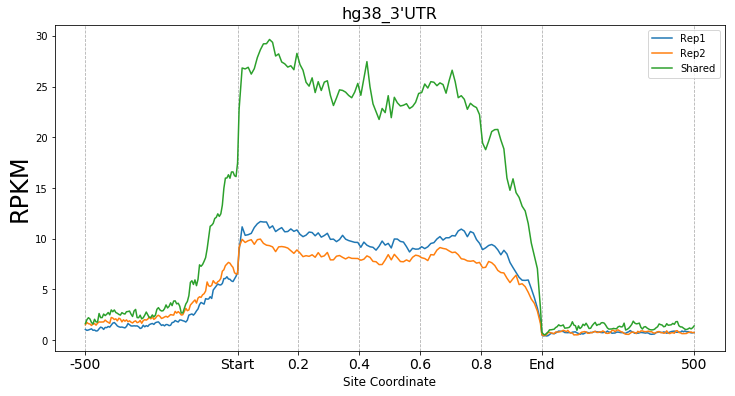

In [101]:
genes_set_name="hg38_3'UTR"
site_name="hg38_3'UTR"
con_name="Rep1"
profile_Up_genebody_Down_site(norm_profile_TSS, norm_profile, norm_profile_TES, norm_profile2_TSS, norm_profile_2, norm_profile2_TES,
                              norm_profile3_TSS, norm_profile_3, norm_profile3_TES, resolution, genic_partition,
                                  upstreamExtension, upstreamExtension, genes_set_name, site_name, con_name, "Rep2","Shared")